# ASX Short Interest Signal

## Import Libraries

In [150]:
import pandas as pd
import datetime as dt
import tabula
import sys, subprocess
from pandas.tseries.offsets import BDay
import yfinance as yf
import time
import numpy as np
import tabula, concurrent.futures, functools
import concurrent.futures
import time, random, concurrent.futures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm


## Import Data
### Extracting and cleaning 52 weeks of ASX short interest data from ASIC. 

In [151]:
# --------- CONFIG ----------
WEEKS_TO_LOAD = 796
BASE = "https://download.asic.gov.au/short-selling/RR{datestr}-001-SSDailyAggShortPos.pdf"

# --------- Helpers ----------
def _norm_cols(cols):
    return [c.strip().lower().replace("\n", " ").replace("  ", " ") for c in cols]

def _num(s):
    return pd.to_numeric(pd.Series(s).astype(str).str.replace(",", "").str.strip(), errors="coerce")

def _is_ticker(x):
    """ASX tickers are 1–6 alphanumeric chars (allow '.'), no spaces."""
    if pd.isna(x): return False
    s = str(x).strip()
    if s.lower().startswith("product code"): return False
    if " " in s: return False
    return 1 <= len(s.replace(".", "")) <= 6 and s.replace(".", "").isalnum()

def _rename_clean_one(df):
    raw, norm = list(df.columns), _norm_cols(df.columns)
    cmap = {}
    for i, c in enumerate(norm):
        if c.startswith("product code"): cmap[raw[i]] = "Ticker"
        elif c.startswith("product"): cmap[raw[i]] = "Company"
        elif "reported short position" in c and "reported as short" not in c:
            cmap[raw[i]] = "Short Positions"
        elif "total product in issue" in c and "reported as short" not in c:
            cmap[raw[i]] = "Total Volume"
        elif "% of total product in issue reported as short positions" in c or c.endswith("short positions"):
            cmap[raw[i]] = "Shorts (%)"
    df = df.rename(columns=cmap)
    keep = ["Company","Ticker","Short Positions","Total Volume","Shorts (%)"]
    df = df[[c for c in keep if c in df.columns]].copy()
    if "Ticker" in df.columns:
        df = df[df["Ticker"].apply(_is_ticker)]
    if "Short Positions" in df.columns:
        df["Short Positions"] = _num(df["Short Positions"])
    if "Total Volume" in df.columns:
        df["Total Volume"] = _num(df["Total Volume"])
    if "Shorts (%)" in df.columns:
        df["Shorts (%)"] = pd.to_numeric(df["Shorts (%)"], errors="coerce")
    if "Shorts (%)" not in df.columns and {"Short Positions","Total Volume"}.issubset(df.columns):
        df["Shorts (%)"] = (df["Short Positions"] / df["Total Volume"]) * 100
    for col in keep:
        if col not in df.columns: df[col] = pd.NA
    return df[keep]

def _read_all_tables(url):
    for kw in (dict(lattice=True), dict(stream=True)):
        try:
            t = tabula.read_pdf(url, pages="all", multiple_tables=True, **kw)
            if t and len(t) > 0:
                return t
        except Exception:
            pass
    return []

def most_recent_friday(ref_date=None):
    if ref_date is None:
        ref_date = dt.date.today()
    offset = (ref_date.weekday() - 4) % 7
    return ref_date - dt.timedelta(days=offset)

def fetch_eow_for_friday(friday_date: dt.date, max_back_days=6) -> pd.DataFrame:
    for delta in range(0, max_back_days+1):
        day = friday_date - dt.timedelta(days=delta)
        ds = day.strftime("%Y%m%d")
        url = BASE.format(datestr=ds)
        tables = _read_all_tables(url)
        if not tables: continue
        cleaned = []
        for t in tables:
            if isinstance(t, pd.DataFrame) and len(t) >= 4 and len(t) > 0:
                cleaned.append(_rename_clean_one(t.dropna(how="all")))
        if not cleaned: continue
        out = pd.concat(cleaned, ignore_index=True).drop_duplicates()
        if not out.empty:
            release_dt = pd.to_datetime(ds, format="%Y%m%d")
            asof_dt = (release_dt - BDay(4)).normalize()
            out.insert(0, "Date", asof_dt)
            out.insert(1, "ReleaseDate", release_dt)
            return out
    return pd.DataFrame()

# --------- MAIN ----------
anchor_friday = most_recent_friday()
fridays = [anchor_friday - dt.timedelta(weeks=k) for k in range(WEEKS_TO_LOAD)]

with concurrent.futures.ThreadPoolExecutor(max_workers=6) as ex:
    frames = list(ex.map(fetch_eow_for_friday, fridays))

frames = [f for f in frames if not f.empty]
if not frames:
    raise RuntimeError("No ASIC EOW reports could be fetched. Check internet/Java (tabula).")

hist_df = (pd.concat(frames, ignore_index=True)
              .drop_duplicates(subset=["Date","Ticker"])
              .sort_values(["Date","Ticker"])
              .reset_index(drop=True))

# ---------- Filter: Keep only equities (ORDINARY shares) ----------
before = len(hist_df)
hist_df = hist_df[hist_df["Company"].str.contains("ORDINARY", case=False, na=False)]
after = len(hist_df)
print(f"Filtered out {before - after} non-ordinary securities (bonds, ETFs, hybrids).")

# ---------- Summary ----------
print(f"\nLoaded {hist_df['Date'].dt.date.nunique()} as-of dates, "
      f"{hist_df['Ticker'].nunique()} unique tickers, "
      f"{len(hist_df)} total rows (equities only).")

Filtered out 63105 non-ordinary securities (bonds, ETFs, hybrids).

Loaded 794 as-of dates, 2461 unique tickers, 370279 total rows (equities only).


In [152]:
# ---------- Preview ----------
print("\nPreview of cleaned ASIC short data:")
display(
    hist_df.tail(10)[
        ["Date", "ReleaseDate", "Ticker", "Company",
         "Short Positions", "Total Volume", "Shorts (%)"]
    ]
)


Preview of cleaned ASIC short data:


,Date,ReleaseDate,Ticker,Company,Short Positions,Total Volume,Shorts (%)
433366,2025-08-25,2025-08-29,WHK,WHITEHAWK LIMITED ORDINARY,69610,876984963,0.0100
433367,2025-08-25,2025-08-29,WJL,WEBJET GROUP LIMITED ORDINARY,1611311,392530357,0.4100
433368,2025-08-25,2025-08-29,WMG,WESTERN MINES ORDINARY,292,97188344,0.0000
433369,2025-08-25,2025-08-29,WOR,WORLEY LIMITED ORDINARY,1114741,516038800,0.2200
433370,2025-08-25,2025-08-29,WOW,WOOLWORTHS GROUP LTD ORDINARY,13150454,1221595333,1.0800
433372,2025-08-25,2025-08-29,WR1,WINSOME RESOURCES ORDINARY,35701,243968451,0.0100
433373,2025-08-25,2025-08-29,WTC,WISETECH GLOBAL LTD ORDINARY,4636717,334622986,1.3900
433379,2025-08-25,2025-08-29,XRO,XERO LTD ORDINARY,1818173,165381624,1.1000
433382,2025-08-25,2025-08-29,YAL,YANCOAL AUST LTD ORDINARY,33084385,1320439437,2.5100
433383,2025-08-25,2025-08-29,ZIP,ZIP CO LTD.. ORDINARY,39618419,1290833227,3.0700


### Add share price at release date (account for delay) and trading date as well as free float, SI (% of free float), and market cap

In [153]:
# ---------- Add Symbol + Normalized dates ----------
work = hist_df.copy()
work["Symbol"] = work["Ticker"].str.upper().str.strip() + ".AX"
work["Date_norm"] = pd.to_datetime(work["Date"]).dt.normalize()
work["ReleaseDate_norm"] = pd.to_datetime(work["ReleaseDate"]).dt.normalize()

syms = sorted(work["Symbol"].dropna().unique())
start = pd.to_datetime(work[["Date_norm","ReleaseDate_norm"]].min().min()) - pd.Timedelta(days=2)
end   = pd.to_datetime(work[["Date_norm","ReleaseDate_norm"]].max().max()) + pd.Timedelta(days=5)

# ---------- Float snapshot with fallback ----------
def _safe_float_info(sym: str) -> dict:
    out = {
        "Symbol": sym,
        "floatShares": np.nan,
        "sharesOutstanding": np.nan,
        "heldPercentInsiders": np.nan,
        "marketCap": np.nan,   # <— add snapshot market cap as a fallback
    }
    try:
        tkr = yf.Ticker(sym)
        fi = getattr(tkr, "fast_info", None)
        if fi:
            out["sharesOutstanding"] = getattr(fi, "shares_outstanding", np.nan)
            out["floatShares"] = getattr(fi, "shares_float", np.nan)
            out["marketCap"] = getattr(fi, "market_cap", np.nan)

        if pd.isna(out["floatShares"]) or pd.isna(out["sharesOutstanding"]) or pd.isna(out["marketCap"]):
            try:
                info = tkr.get_info()
            except Exception:
                info = getattr(tkr, "info", {}) or {}
            if info:
                fs  = info.get("floatShares")
                so  = info.get("sharesOutstanding") or info.get("impliedSharesOutstanding")
                hpi = info.get("heldPercentInsiders")
                mc  = info.get("marketCap")
                if fs not in (None, ""):
                    out["floatShares"] = float(fs)
                if so not in (None, ""):
                    out["sharesOutstanding"] = float(so)
                if isinstance(hpi, (int, float)):
                    out["heldPercentInsiders"] = float(hpi)
                if mc not in (None, ""):
                    out["marketCap"] = float(mc)
    except Exception:
        pass
    return out

float_df = pd.DataFrame(_safe_float_info(s) for s in syms)
work = work.merge(float_df, on="Symbol", how="left")

# ---------- Free Float Estimate ----------
ff_from_insiders = work["sharesOutstanding"] * (1 - work["heldPercentInsiders"].fillna(0))
ff_candidates = pd.concat([work["floatShares"], ff_from_insiders], axis=1)
work["Date Free Float"] = ff_candidates.max(axis=1)

# ---------- Short Interest as % of free float ----------
m_ff = work["Short Positions"].notna() & work["Date Free Float"].gt(0)
work.loc[m_ff, "Shorts (Free Float %)"] = 100 * work.loc[m_ff, "Short Positions"] / work.loc[m_ff, "Date Free Float"]

# ---------- Price history (batch to reduce errors) ----------
batch_size = 50
price_frames = []
for i in range(0, len(syms), batch_size):
    batch = syms[i:i+batch_size]
    try:
        data = yf.download(
            batch,
            start=start.strftime("%Y-%m-%d"),
            end=end.strftime("%Y-%m-%d"),
            auto_adjust=False,
            progress=False,
            threads=True,
        )
        if "Close" in data.columns:   # Multi-ticker DataFrame
            data = data["Close"]
        elif isinstance(data, pd.Series):  # Single ticker fallback
            data = data.to_frame(name=batch[0])
        data.index = pd.to_datetime(data.index).normalize()
        price_frames.append(data)
        print(f"✓ Batch {i//batch_size+1}: {len(batch)} tickers")
    except Exception as e:
        print(f"⚠️ Batch {i//batch_size+1} failed: {e}")

prices = pd.concat(price_frames, axis=1).sort_index() if price_frames else pd.DataFrame()

# ---------- Align prices to Date & ReleaseDate ----------
asof_idx = pd.to_datetime(work["Date_norm"].unique())
rel_idx  = pd.to_datetime(work["ReleaseDate_norm"].unique())

asof_price = prices.reindex(asof_idx, method="bfill").stack().reset_index()
asof_price.columns = ["Date_norm","Symbol","Date Share Price"]

rel_price = prices.reindex(rel_idx, method="bfill").stack().reset_index()
rel_price.columns = ["ReleaseDate_norm","Symbol","Release Date Share Price"]

# ---------- Merge back ----------
hist_df = (work
    .merge(asof_price, on=["Date_norm","Symbol"], how="left")
    .merge(rel_price, on=["ReleaseDate_norm","Symbol"], how="left")
)

# ---------- Market cap columns ----------
# Prefer dynamic calc (price × sharesOutstanding). If sharesOutstanding missing, fall back to snapshot marketCap.
for col_price, col_out in [
    ("Date Share Price", "Date Market Cap"),
    ("Release Date Share Price", "Release Date Market Cap"),
]:
    hist_df[col_out] = np.where(
        hist_df["sharesOutstanding"].notna(),
        hist_df[col_price] * hist_df["sharesOutstanding"],
        np.nan
    )
    # fallback to snapshot mkt cap only if still NaN
    hist_df[col_out] = hist_df[col_out].fillna(hist_df["marketCap"])

# now drop helper cols we don't want to keep
hist_df = (hist_df
    .drop(columns=[
        "Symbol","Date_norm","ReleaseDate_norm",
        "floatShares","heldPercentInsiders","marketCap"  # keep/drop sharesOutstanding as you prefer
    ])
    .sort_values(["Date","Ticker"])
    .reset_index(drop=True)
)

# ---------- Drop bad rows (require all critical fields) ----------
critical_cols = ["Date Share Price","Release Date Share Price","Date Free Float","Shorts (Free Float %)"]
hist_df = hist_df.dropna(subset=critical_cols)

# ---------- Preview ----------
print("Final cleaned dataset:")
print("Prices on Date:", hist_df["Date Share Price"].notna().sum(), "/", len(hist_df))
print("Prices on ReleaseDate:", hist_df["Release Date Share Price"].notna().sum(), "/", len(hist_df))
print("Free float present:", hist_df["Date Free Float"].notna().sum(), "/", len(hist_df))
print(">100% after fix:", (hist_df["Shorts (Free Float %)"] > 100).sum())

display(hist_df.head(12)[[
    "Date","ReleaseDate","Ticker","Company",
    "Short Positions","Total Volume","Shorts (%)",
    "Date Free Float","Shorts (Free Float %)",
    "Date Share Price","Release Date Share Price",
    "Date Market Cap","Release Date Market Cap"
]])

$4DS.AX: possibly delisted; no price data found  (period=5d)
$92E.AX: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
$92E.AX: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$A2B.AX: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
$A2B.AX: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$ABA.AX: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
$ABA.AX: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$ABC.AX: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
$ABC.AX: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
HTT

✓ Batch 1: 50 tickers



14 Failed downloads:
['AED.AX', 'AGK.AX', 'ADU.AX', 'AGF.AX', 'AFY.AX', 'AEJ.AX', 'AEK.AX', 'AEO.AX', 'ACG.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['ADJ.AX', 'AGJ.AX', 'AFJ.AX', 'ACN.AX', 'ADA.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 2: 50 tickers



18 Failed downloads:
['AIK.AX', 'AIO.AX', 'AHE.AX', 'AIX.AX', 'AKK.AX', 'AHD.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['AHY.AX', 'AJC.AX', 'ALG.AX', 'AGS.AX', 'AHZ.AX', 'AHQ.AX', 'AIR.AX', 'AHG.AX', 'AKE.AX', 'ALF.AX', 'AJM.AX', 'AKI.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 3: 50 tickers



19 Failed downloads:
['AOE.AX', 'APN.AX', 'AOC.AX', 'ALS.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['ANA.AX', 'AND.AX', 'ALU.AX', 'APT.AX', 'APD.AX', 'AMM.AX', 'AML.AX', 'APM.AX', 'API.AX', 'ANW.AX', 'AOU.AX', 'AOP.AX', 'AMB.AX', 'AMG.AX', 'ANP.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 4: 50 tickers



13 Failed downloads:
['ARP.AX', 'ARW.AX', 'AQA.AX', 'ASZ.AX', 'ATI.AX', 'AQP.AX', 'APY.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['ARQ.AX', 'ARE.AX', 'ASO.AX', 'ARM.AX', 'ATL.AX', 'AST.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 5: 50 tickers



13 Failed downloads:
['AXA.AX', 'AYN.AX', 'AXO.AX', 'AWB.AX', 'AXM.AX', 'AVX.AX', 'AVO.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['AWV.AX', 'AYS.AX', 'AUT.AX', 'AU8.AX', 'AWC.AX', 'AVZ.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 6: 50 tickers



20 Failed downloads:
['AZM.AX', 'BDA.AX', 'BAL.AX', 'BDC.AX', 'AZH.AX', 'BDR.AX', 'AZS.AX', 'BAF.AX', 'BAT.AX', 'B2Y.AX', 'BD1.AX', 'AZT.AX', 'AZG.AX', 'BAU.AX', 'BBX.AX', 'BEM.AX', 'BAR.AX']: YFTzMissingError('possibly delisted; no timezone found')
['AZX.AX', 'AZO.AX', 'AZZ.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')


✓ Batch 7: 50 tickers



20 Failed downloads:
['BOM.AX', 'BMB.AX', 'BOW.AX', 'BIG.AX', 'BKN.AX', 'BND.AX', 'BPA.AX', 'BLR.AX', 'BKP.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['BLY.AX', 'BLK.AX', 'BLA.AX', 'BNO.AX', 'BME.AX', 'BIN.AX', 'BLD.AX', 'BLT.AX', 'BID.AX', 'BGS.AX', 'BKL.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 8: 50 tickers



21 Failed downloads:
['BRS.AX', 'BPS.AX', 'BVA.AX', 'BTT.AX', 'BTU.AX', 'BTV.AX', 'BRM.AX', 'BYR.AX', 'BRC.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['BRV.AX', 'BUL.AX', 'BSE.AX', 'BYE.AX', 'BTH.AX', 'BST.AX', 'BSM.AX', 'BZL.AX', 'BUD.AX', 'BRB.AX', 'BWX.AX', 'BSR.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 9: 50 tickers



19 Failed downloads:
['CCC.AX', 'CAH.AX', 'CCU.AX', 'CAB.AX', 'CEG.AX', 'CBX.AX', 'CBB.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['CDD.AX', 'CAI.AX', 'CAD.AX', 'CDV.AX', 'CDY.AX', 'CAS.AX', 'CE1.AX', 'CAP.AX', 'CAU.AX', 'CAJ.AX', 'CBR.AX', 'CCZ.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 10: 50 tickers



25 Failed downloads:
['CLL.AX', 'CEY.AX', 'CHP.AX', 'CGH.AX', 'CGG.AX', 'CIG.AX', 'CIR.AX', 'CIL.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['CGN.AX', 'CLH.AX', 'CL1.AX', 'CGM.AX', 'CLT.AX', 'CGA.AX', 'CLF.AX', 'CGL.AX', 'CIM.AX', 'CGC.AX', 'CHK.AX', 'CFE.AX', 'CGB.AX', 'CLI.AX', 'CHZ.AX', 'CLQ.AX', 'CJO.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 11: 50 tickers



21 Failed downloads:
['CPB.AX', 'CNA.AX', 'CMR.AX', 'COK.AX', 'COZ.AX', 'CMV.AX', 'CPS.AX', 'COU.AX', 'CO1.AX', 'CPL.AX', 'CNK.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['CNR.AX', 'CNX.AX', 'COO.AX', 'CPZ.AX', 'CNW.AX', 'COE.AX', 'CNL.AX', 'CM8.AX', 'CMA.AX', 'CPH.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 12: 50 tickers



18 Failed downloads:
['CRH.AX', 'CRG.AX', 'CRE.AX', 'CUA.AX', 'CRZ.AX', 'CVO.AX', 'CWE.AX', 'CRK.AX', 'CQT.AX', 'CR8.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['CTX.AX', 'CSV.AX', 'CSJ.AX', 'CVT.AX', 'CRO.AX', 'CSR.AX', 'CV1.AX', 'CRW.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 13: 50 tickers



17 Failed downloads:
['CXP.AX', 'CYU.AX', 'CXS.AX', 'CXB.AX', 'CXY.AX', 'CZA.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['CWN.AX', 'CZI.AX', 'DDD.AX', 'DDH.AX', 'DCG.AX', 'DEX.AX', 'CZL.AX', 'DEG.AX', 'DCN.AX', 'DAU.AX', 'DFM.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 14: 50 tickers



21 Failed downloads:
['DKO.AX', 'DTE.AX', 'DRG.AX', 'DRK.AX', 'DSH.AX', 'DOM.AX', 'DLS.AX', 'DJS.AX', 'DML.AX', 'DKN.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['DSE.AX', 'DTQ.AX', 'DGO.AX', 'DOU.AX', 'DLX.AX', 'DTC.AX', 'DLC.AX', 'DRM.AX', 'DRA.AX', 'DN8.AX', 'DTS.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 15: 50 tickers



23 Failed downloads:
['EFG.AX', 'DYE.AX', 'EGP.AX', 'ELM.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['EGS.AX', 'ECX.AX', 'EAS.AX', 'EGO.AX', 'E2M.AX', 'DVN.AX', 'EM1.AX', 'DW8.AX', 'E33.AX', 'ELK.AX', 'EGA.AX', 'EHE.AX', 'ELX.AX', 'EEG.AX', 'ELO.AX', 'EGN.AX', 'DWS.AX', 'E2E.AX', 'EAR.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 16: 50 tickers



19 Failed downloads:
['EPT.AX', 'ESG.AX', 'EUG.AX', 'EMX.AX', 'ESN.AX', 'EPG.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['ENE.AX', 'EPD.AX', 'ENA.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['ERW.AX', 'ESS.AX', 'EUC.AX', 'EP1.AX', 'ESH.AX', 'EPW.AX', 'ERX.AX', 'ESV.AX', 'EN1.AX', 'ETE.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 17: 50 tickers



18 Failed downloads:
['FGE.AX', 'EZE.AX', 'EXS.AX', 'FAN.AX', 'FCR.AX', 'EXC.AX', 'EXE.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['FDM.AX', 'EXU.AX', 'FEL.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['FFX.AX', 'FGL.AX', 'FGO.AX', 'FFR.AX', 'EX1.AX', 'FEO.AX', 'FFF.AX', 'FFT.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 18: 50 tickers



19 Failed downloads:
['FSE.AX', 'FRR.AX', 'FTE.AX', 'G8C.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['FYA.AX', 'FNP.AX', 'FZO.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['FSF.AX', 'FTT.AX', 'FYI.AX', 'FNT.AX', 'FXL.AX', 'FIG.AX', 'FTD.AX', 'FMS.AX', 'FIJ.AX', 'FTZ.AX', 'FOD.AX', 'FRSN.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 19: 50 tickers



23 Failed downloads:
['GMI.AX', 'GEG.AX', 'GCS.AX', 'GIR.AX', 'GFF.AX', 'GMM.AX', 'GDY.AX', 'GCL.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['GBG.AX', 'GMR.AX', 'GDA.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['GCY.AX', 'GFN.AX', 'GBT.AX', 'GMV.AX', 'GMA.AX', 'GME.AX', 'GGG.AX', 'GBP.AX', 'GEV.AX', 'GFE.AX', 'GLV.AX', 'GCLN.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 20: 50 tickers



15 Failed downloads:
['GOT.AX', 'GUF.AX', 'GWT.AX', 'GRK.AX', 'GRY.AX', 'GTP.AX', 'GOA.AX', 'GSC.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['GXL.AX', 'GRB.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['GXY.AX', 'GNX.AX', 'GPP.AX', 'GUD.AX', 'GSW.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 21: 50 tickers



17 Failed downloads:
['HFA.AX', 'HEG.AX', 'HOM.AX', 'HSP.AX', 'HUN.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['HLA.AX', 'HRR.AX', 'HLSNB.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['HSO.AX', 'HUO.AX', 'HIL.AX', 'HT1.AX', 'HNR.AX', 'HHI.AX', 'HHY.AX', 'HOT.AX', 'HIG.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 22: 50 tickers



15 Failed downloads:
['IIL.AX', 'IIN.AX', 'IFE.AX', 'IDG.AX', 'IFZ.AX', 'IBY.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['ICQ.AX', 'IAU.AX', 'HXG.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['IKW.AX', 'IBG.AX', 'IAP.AX', 'HYM.AX', 'IHR.AX', 'IHL.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 23: 50 tickers



20 Failed downloads:
['ISF.AX', 'IOH.AX', 'IPP.AX', 'ISN.AX', 'IRN.AX', 'IQE.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['IPL.AX', 'INP.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['IMS.AX', 'IP1.AX', 'IVO.AX', 'ISD.AX', 'ISX.AX', 'ITG.AX', 'IVC.AX', 'ISU.AX', 'IMF.AX', 'INL.AX', 'IOT.AX', 'IOU.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 24: 50 tickers



16 Failed downloads:
['JML.AX', 'JAG.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['KIL.AX', 'JHC.AX', 'KAS.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['JRV.AX', 'JDR.AX', 'KDR.AX', 'JHL.AX', 'KFE.AX', 'JRL.AX', 'KIN.AX', 'KGM.AX', 'JXT.AX', 'KIS.AX', 'IXU.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 25: 50 tickers



17 Failed downloads:
['LEI.AX', 'KRC.AX', 'KSO.AX', 'LDW.AX', 'KZL.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['LBY.AX', 'LER.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['KWR.AX', 'KTD.AX', 'KYK.AX', 'KNL.AX', 'LCK.AX', 'KZA.AX', 'LBT.AX', 'LAA.AX', 'LCM.AX', 'LCT.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 26: 50 tickers



11 Failed downloads:
['LRC.AX', 'LMR.AX', 'LFR.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['LNG.AX', 'LRL.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['LPI.AX', 'LV1.AX', 'LRS.AX', 'LON.AX', 'LNK.AX', 'LLI.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 27: 50 tickers



17 Failed downloads:
['MCU.AX', 'LWP.AX', 'MBN.AX', 'MAK.AX', 'MBE.AX', 'MCC.AX', 'MAE.AX', 'MCS.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['ME1.AX', 'MCR.AX', 'MCL.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['LVH.AX', 'MAI.AX', 'LYN.AX', 'MCT.AX', 'MEB.AX', 'MEA.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 28: 50 tickers



20 Failed downloads:
['MLI.AX', 'MIZ.AX', 'MKB.AX', 'MGO.AX', 'MMW.AX', 'MLB.AX', 'MEO.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['MMJ.AX', 'MKG.AX', 'MLT.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['MLD.AX', 'MEP.AX', 'MIL.AX', 'MLL.AX', 'MEY.AX', 'MGG.AX', 'MLM.AX', 'MHH.AX', 'MGV.AX', 'MGC.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 29: 50 tickers



26 Failed downloads:
['MNM.AX', 'MOX.AX', 'MSF.AX', 'MOL.AX', 'MQA.AX', 'MOS.AX', 'MNQ.AX', 'MMX.AX', 'MRU.AX', 'MOO.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['MSM.AX', 'MNY.AX', 'MOQ.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['MRG.AX', 'MNW.AX', 'MRM.AX', 'MRP.AX', 'MSR.AX', 'MSL.AX', 'MOD.AX', 'MOC.AX', 'MOY.AX', 'MOE.AX', 'MR1.AX', 'MNF.AX', 'MOB.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 30: 50 tickers



24 Failed downloads:
['MTU.AX', 'MUS.AX', 'MTE.AX', 'MUM.AX', 'MUX.AX', 'NBS.AX', 'NAD.AX', 'MYT.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['MZZ.AX', 'NCZ.AX', 'MYO.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['MWR.AX', 'NBI.AX', 'NBL.AX', 'MZI.AX', 'MYD.AX', 'MYQ.AX', 'MWY.AX', 'NCM.AX', 'MTR.AX', 'MXC.AX', 'MYL.AX', 'NEA.AX', 'MXR.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 31: 50 tickers



17 Failed downloads:
['NRT.AX', 'NGF.AX', 'NEN.AX', 'NQM.AX', 'NFE.AX', 'NSL.AX', 'NPX.AX', 'NRL.AX', 'NFK.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['NTC.AX', 'NKL.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['NHL.AX', 'NSE.AX', 'NML.AX', 'NOC.AX', 'NEW.AX', 'NMS.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 32: 50 tickers



18 Failed downloads:
['NWT.AX', 'OBS.AX', 'NYO.AX', 'NWZ.AX', 'NXR.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['OGH.AX', 'OAR.AX', 'NVL.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['NTO.AX', 'OEG.AX', 'NUS.AX', 'NVT.AX', 'OCP.AX', 'NZC.AX', 'OEX.AX', 'OBJ.AX', 'NZO.AX', 'NWE.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 33: 50 tickers



21 Failed downloads:
['OMT.AX', 'OTC.AX', 'OZB.AX', 'OMI.AX', 'OKN.AX', 'OST.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['OTW.AX', 'OPY.AX', 'ORR.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['OSH.AX', 'PAL.AX', 'OPC.AX', 'ONT.AX', 'OZL.AX', 'OPA.AX', 'OVH.AX', 'OKR.AX', 'OMN.AX', 'OKU.AX', 'OVN.AX', 'PAA.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 34: 50 tickers



20 Failed downloads:
['PCP.AX', 'PBG.AX', 'PFL.AX', 'PHK.AX', 'PDY.AX', 'PEP.AX', 'PHG.AX', 'PBD.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['PGI.AX', 'PG1.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['PBT.AX', 'PDZ.AX', 'PGR.AX', 'PF1.AX', 'PBP.AX', 'PEA.AX', 'PDL.AX', 'PGL.AX', 'PGX.AX', 'PGG.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 35: 50 tickers



14 Failed downloads:
['PRA.AX', 'PPP.AX', 'PIR.AX', 'POK.AX', 'PLV.AX', 'PPX.AX', 'PMP.AX', 'PNA.AX', 'PRC.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['PIO.AX', 'POS.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['PMY.AX', 'PNL.AX', 'POH.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 36: 50 tickers



15 Failed downloads:
['PRR.AX', 'PSY.AX', 'PRY.AX', 'PXG.AX', 'PSP.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['PSA.AX', 'PTB.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['PXS.AX', 'PRT.AX', 'PYR.AX', 'QHL.AX', 'PSI.AX', 'PTG.AX', 'PWL.AX', 'PVD.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 37: 50 tickers



18 Failed downloads:
['RDR.AX', 'QMN.AX', 'RCG.AX', 'RFE.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['REF.AX', 'RAP.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['RED.AX', 'RCW.AX', 'RDT.AX', 'RDH.AX', 'RBL.AX', 'RCP.AX', 'RES.AX', 'RDF.AX', 'QIP.AX', 'RE1.AX', 'QRN.AX', 'QMS.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 38: 50 tickers



19 Failed downloads:
['RNS.AX', 'RHG.AX', 'RNI.AX', 'RFL.AX', 'ROL.AX', 'RIV.AX', 'RGX.AX', 'RIA.AX', 'ROY.AX', 'RPX.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['RFN.AX', 'RLE.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['RNE.AX', 'RQL.AX', 'RMP.AX', 'RGI.AX', 'ROS.AX', 'RHL.AX', 'RHP.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 39: 50 tickers



22 Failed downloads:
['SBL.AX', 'SAI.AX', 'RWH.AX', 'RUM.AX', 'SDM.AX', 'SEV.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['SF1.AX', 'SCL.AX', 'SES.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['SE1.AX', 'SDA.AX', 'RXM.AX', 'RVR.AX', 'SEA.AX', 'RRS.AX', 'SCU.AX', 'SAR.AX', 'SDG.AX', 'RSH.AX', 'RXP.AX', 'SAS.AX', 'RYZ.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 40: 50 tickers



15 Failed downloads:
['SFZ.AX', 'SLV.AX', 'SIR.AX', 'SFW.AX', 'SFH.AX', 'SGN.AX', 'SIP.AX', 'SKE.AX', 'SKB.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['SLR.AX', 'SKF.AX', 'SGF.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['SLK.AX', 'SI6.AX', 'SIH.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 41: 50 tickers



13 Failed downloads:
['SNY.AX', 'SPI.AX', 'SPH.AX', 'SRQ.AX', 'SOO.AX', 'SRM.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['SOV.AX', 'SPM.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['SPO.AX', 'SO4.AX', 'SRS.AX', 'SPT.AX', 'SRX.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 42: 50 tickers



16 Failed downloads:
['STB.AX', 'SWL.AX', 'SWW.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['SVH.AX', 'SXG.AX', 'SWF.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['SXY.AX', 'SUD.AX', 'SWK.AX', 'SVW.AX', 'SYT.AX', 'SYM.AX', 'STC.AX', 'TAP.AX', 'SUR.AX', 'SUV.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 43: 50 tickers



19 Failed downloads:
['TCM.AX', 'TCH.AX', 'TIS.AX', 'TEL.AX', 'TIM.AX', 'TEN.AX', 'TFC.AX', 'TIX.AX', 'TFG.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['TGA.AX', 'THX.AX', 'TGG.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['TMR.AX', 'TDI.AX', 'TME.AX', 'THC.AX', 'TIE.AX', 'TBH.AX', 'TGR.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 44: 50 tickers



29 Failed downloads:
['TPT.AX', 'TSV.AX', 'TOL.AX', 'TTW.AX', 'TTN.AX', 'TOF.AX', 'TRG.AX', 'TPN.AX', 'TPI.AX', 'TTS.AX', 'TSM.AX', 'TTY.AX', 'TRO.AX', 'TSE.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['TNR.AX', 'TPE.AX', 'TTB.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['TNO.AX', 'TSN.AX', 'TRT.AX', 'TPM.AX', 'TNT.AX', 'TRY.AX', 'TNG.AX', 'TSC.AX', 'TNK.AX', 'TPD.AX', 'TMT.AX']: YFTzMissingError('possibly delisted; no timezone found')
['TRS.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03) (Yahoo error = "No data found, symbol may be delisted")')


✓ Batch 45: 50 tickers



20 Failed downloads:
['UXA.AX', 'UGL.AX', 'VEI.AX', 'VED.AX', 'VBA.AX', 'UNX.AX', 'VET.AX', 'UML.AX', 'VGH.AX', 'UXC.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['TYM.AX', 'TV2.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['VG8.AX', 'VAH.AX', 'VEC.AX', 'VAN.AX', 'UWL.AX', 'VAL.AX', 'UMG.AX', 'VGI.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 46: 50 tickers



19 Failed downloads:
['VMY.AX', 'VPC.AX', 'VTG.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['VXR.AX', 'VIC.AX', 'VMS.AX', 'VTH.AX', 'VLT.AX', 'VOC.AX', 'VHT.AX', 'VMX.AX', 'VIRDA.AX', 'VOR.AX', 'VOL.AX', 'VRT.AX', 'VLW.AX']: YFTzMissingError('possibly delisted; no timezone found')
['VWM.AX', 'VRE.AX', 'VPE.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')


✓ Batch 47: 50 tickers



22 Failed downloads:
['WMN.AX', 'WFM.AX', 'WHE.AX', 'WCB.AX', 'WCP.AX', 'WHG.AX', 'WAS.AX', 'WBB.AX', 'WCL.AX', 'WHN.AX', 'WDR.AX', 'WAN.AX', 'WHS.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['WLL.AX', 'WBA.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['WLF.AX', 'WHA.AX', 'WMC.AX', 'WCG.AX', 'WGF.AX', 'WGO.AX', 'WJA.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 48: 50 tickers



21 Failed downloads:
['YTC.AX', 'WVL.AX', 'XXL.AX', 'WTF.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['WNI.AX', 'XTD.AX', 'Z2U.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['WPP.AX', 'YFZ.AX', 'WRM.AX', 'WPG.AX', 'WSA.AX', 'XIP.AX', 'WSP.AX', 'WPL.AX', 'WND.AX', 'ZEL.AX', 'XTE.AX', 'YBR.AX', 'XPE.AX', 'Z1P.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 49: 50 tickers



5 Failed downloads:
['ZYL.AX', 'ZML.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-03)')
['ZEN.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['ZNZ.AX', 'ZER.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 50: 11 tickers
Final cleaned dataset:
Prices on Date: 226648 / 226648
Prices on ReleaseDate: 226648 / 226648
Free float present: 226648 / 226648
>100% after fix: 555


,Date,ReleaseDate,Ticker,Company,Short Positions,Total Volume,Shorts (%),Date Free Float,Shorts (Free Float %),Date Share Price,Release Date Share Price,Date Market Cap,Release Date Market Cap
70,2010-06-14,2010-06-18,CDU,CUDECO LIMITED ORDINARY,753797,137285632,0.5600,"394,278,016.0000",0.1912,3.7696,3.9993,"1,486,253,078.8333","1,576,837,668.6465"
199,2010-06-14,2010-06-18,MPO,MOLOPO ENERGY LTD ORDINARY,11281,250665548,0.0000,"249,040,992.0000",0.0045,1.0550,1.1400,"262,738,233.4973","283,906,727.3174"
268,2010-06-14,2010-06-18,SDL,SUNDANCE RESOURCES ORDINARY,18973425,2709995932,0.6900,"9,450,019,840.0000",0.2008,0.1300,0.1300,"1,228,502,534.1388","1,228,502,534.1388"
335,2010-06-21,2010-06-25,AAC,AUSTRALIAN AGRICULT. ORDINARY,5383914,264264459,2.0400,"135,761,230.1152",3.9657,1.4291,1.4103,"861,416,103.8612","850,081,629.4413"
339,2010-06-21,2010-06-25,ACR,ACRUX LIMITED ORDINARY,123421,160556216,0.0700,"335,752,000.3200",0.0368,1.8750,1.8300,"767,370,000.0000","748,953,137.5637"
340,2010-06-21,2010-06-25,ADD,ADAVALE RESOURCE LTD ORDINARY,138644,183593979,0.0800,"147,835,095.9673",0.0938,11.2708,11.9980,"2,060,092,121.7799","2,193,001,139.1055"
349,2010-06-21,2010-06-25,AIA,AUCKLAND INTERNATION ORDINARY,54,1310392831,0.0000,"1,687,687,048.0000",0.0000,1.7389,1.7167,"2,935,434,180.8952","2,897,920,930.4999"
350,2010-06-21,2010-06-25,AIQ,ALTERNATIVE INVEST ORDINARY UNITS,15000,130692470,0.0100,"18,930,806.1800",0.0792,1.0300,1.0350,"35,025,561.0271","35,195,587.8649"
352,2010-06-21,2010-06-25,AJL,AJ LUCAS GROUP ORDINARY,423513,65276374,0.6500,"1,216,613,110.6483",0.0348,1.7397,1.5671,"2,393,382,273.1093","2,155,943,688.3007"
353,2010-06-21,2010-06-25,ALL,ARISTOCRAT LEISURE ORDINARY,19286065,533379348,3.6100,"553,593,782.0000",3.4838,3.9442,3.7151,"2,449,147,968.3019","2,306,899,429.9572"


## Adding Signals
- **mom_12w**  
  *12-week momentum.*  
  The percentage return of the share price over the last 12 weeks. Positive momentum means the stock has been trending upwards; negative means downwards.

- **si_percentile_52w**  
  *Short interest percentile (52 weeks).*  
  Where the current short interest (% of free float) ranks compared to the last 52 weeks.  
  - Value near 1.0 → current SI is very high relative to history.  
  - Value near 0.0 → current SI is very low relative to history.

- **si_up_weeks**  
  *Persistence of short builds.*  
  Number of the past 5 weeks where short interest increased.  
  - Higher values indicate consistent short builds.  
  - Used as a persistence signal (e.g., 4/5 weeks up = strong conviction).

- **mom_si_interact**  
  *Momentum × Short interest interaction.*  
  A combined factor capturing when **momentum is negative (price falling)** *and* **short interest is high or rising**.  
  This interaction often points to stocks under pressure from both technicals and positioning.

- **vol_4w**  
  *4-week realized volatility.*  
  The standard deviation of weekly returns over the past 4 weeks.  
  Indicates how volatile the stock has been recently; higher volatility may amplify short opportunities.


In [154]:
# ---------- Build Signals ----------
def build_signals(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    g = df.groupby("Ticker", group_keys=False)

    # --- 1. Momentum (12-week return)
    df["mom_12w"] = g["Date Share Price"].transform(lambda x: x.pct_change(periods=12))

    # --- 2. Short interest percentile (52 weeks)
    def rolling_percentile(x, window=52):
        return x.rolling(window, min_periods=12).apply(
            lambda s: pd.Series(s).rank(pct=True).iloc[-1], raw=False
        )
    df["si_percentile_52w"] = g["Shorts (Free Float %)"].transform(rolling_percentile)

    # --- 3. Persistence of SI build (count of up weeks in last 5)
    def count_up_weeks(x):
        return x.diff().gt(0).rolling(5, min_periods=3).sum()
    df["si_up_weeks"] = g["Shorts (Free Float %)"].transform(count_up_weeks)

    # --- 4. Interaction: momentum × SI
    df["mom_si_interact"] = df["mom_12w"] * df["Shorts (Free Float %)"]

    # --- 5. Volatility (4-week rolling std of returns)
    df["ret_1w"] = g["Date Share Price"].transform(lambda x: x.pct_change(periods=1))
    df["vol_4w"] = g["ret_1w"].transform(lambda x: x.rolling(4, min_periods=3).std())

    return df

# ---------- Apply ----------
signals_df = build_signals(hist_df)

# ---------- Preview ----------
display(signals_df.tail(12)[[
    "Date", "Ticker", "Date Share Price", "Shorts (Free Float %)",
    "mom_12w", "si_percentile_52w", "si_up_weeks",
    "mom_si_interact", "vol_4w"
]])


,Date,Ticker,Date Share Price,Shorts (Free Float %),mom_12w,si_percentile_52w,si_up_weeks,mom_si_interact,vol_4w
370267,2025-08-25,WGX,3.2400,3.0046,0.0983,0.7115,3.0000,0.2954,0.0778
370268,2025-08-25,WHC,6.7300,4.0912,0.2303,0.5192,2.0000,0.9424,0.0540
370269,2025-08-25,WHK,0.0100,0.0107,-0.2857,0.5096,0.0000,-0.0031,0.1012
370270,2025-08-25,WJL,0.9400,0.6334,0.0682,0.0870,0.0000,0.0432,0.0388
370271,2025-08-25,WMG,0.2250,0.0004,0.2162,0.4250,1.0000,0.0001,0.0904
370272,2025-08-25,WOR,12.8700,0.2316,-0.0115,0.0385,2.0000,-0.0027,0.0122
370273,2025-08-25,WOW,32.6100,1.0797,0.0226,0.9423,4.0000,0.0244,0.0086
370274,2025-08-25,WR1,0.1850,0.0172,-0.3729,0.2308,1.0000,-0.0064,0.1344
370275,2025-08-25,WTC,110.7400,2.4963,0.0572,0.9615,1.0000,0.1427,0.0325
370276,2025-08-25,XRO,165.8600,1.1314,-0.0860,0.1731,1.0000,-0.0973,0.0211


## Train model to determine best score
*Lasso Regression*  
Lorem ipsum

In [155]:
# --- Config ---
TRAIN_WEEKS = 400   # train on the earliest N weeks
H = 4               # prediction horizon (exit after H weeks)

# --- Get the data frame ---
if 'panel' in globals() and isinstance(panel, pd.DataFrame):
    df = panel.copy()
elif 'hist_df' in globals() and isinstance(hist_df, pd.DataFrame):
    df = hist_df.copy()
else:
    raise NameError("Need 'panel' or 'hist_df' with at least ['Date','Ticker','Date Share Price'].")

# --- Clean & sort ---
df["Date"] = pd.to_datetime(df["Date"])
df["Date Share Price"] = pd.to_numeric(df["Date Share Price"], errors="coerce")
df = df.sort_values(["Ticker","Date"]).reset_index(drop=True)

# --- Build H-week forward labels (negative long return is good for a short) ---
df["px_t"]  = df["Date Share Price"]
df["px_t4"] = df.groupby("Ticker")["px_t"].shift(-H)
df["ret_fwd_long"]  = (df["px_t4"] - df["px_t"]) / df["px_t"]
df["ret_fwd_short"] = -df["ret_fwd_long"]
df["y_down"] = np.where(df["ret_fwd_long"].notna(), (df["ret_fwd_long"] < 0).astype(int), np.nan)

# --- Features: all numeric columns except excluded ---
exclude = {
    "Date","Ticker","Company","Date Share Price","Release Date Share Price",
    "px_t","px_t4","ret_fwd_long","ret_fwd_short","y_down"
}
ZCOLS = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]
if not ZCOLS:
    raise ValueError("No numeric feature columns found for ZCOLS.")

# --- Training window = earliest TRAIN_WEEKS (drop last H to avoid look-ahead) ---
dates = np.array(sorted(df["Date"].unique()))
total_weeks = len(dates)
need = TRAIN_WEEKS + H + 1
if total_weeks < need:
    raise ValueError(f"Not enough history: have {total_weeks} weeks; need ≥ {need}.")

train_end_idx   = TRAIN_WEEKS - 1
train_end_date  = dates[train_end_idx]
cutoff_for_label = train_end_date - pd.Timedelta(weeks=H)

train = df[(df["Date"] <= cutoff_for_label) & df["y_down"].notna()].copy()
train = train.dropna(subset=ZCOLS)
if train.empty:
    raise ValueError("Training slice empty after cutoff/label filtering.")

# --- Fit classifier for predictions (sklearn) ---
t0 = time.time()
clf = LogisticRegression(penalty="l2", solver="lbfgs", C=1.0, max_iter=1000,
                         fit_intercept=True, class_weight="balanced")
clf.fit(train[ZCOLS].values, train["y_down"].astype(int).values)

# --- ALSO fit a statsmodels Logit to print a full regression summary ---
X_sm = sm.add_constant(train[ZCOLS], has_constant='add')
logit = sm.Logit(train["y_down"].astype(int).values, X_sm.values)
logit_res = logit.fit(disp=False)

print("---- Logistic Regression (statsmodels) summary on TRAIN ----")
print(logit_res.summary2())

# --- Keep commonly used objects in memory for the trading chunk ---
trade_start_idx  = TRAIN_WEEKS                  # first entry = dates[TRAIN_WEEKS]
trade_start_date = dates[trade_start_idx]
print(f"\nTrained on earliest {TRAIN_WEEKS} weeks (through {pd.to_datetime(train_end_date).date()}); "
      f"first trade week will be {pd.to_datetime(trade_start_date).date()}.  "
      f"Fit time: {time.time()-t0:.2f}s")


---- Logistic Regression (statsmodels) summary on TRAIN ----
                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.012      
Date:               2025-09-05 09:29 AIC:              96869.4421 
No. Observations:   70839            BIC:              96951.9556 
Df Model:           8                Log-Likelihood:   -48426.    
Df Residuals:       70830            LL-Null:          -49034.    
Converged:          1.0000           LLR p-value:      2.6445e-257
No. Iterations:     6.0000           Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -0.0798     0.0106    -7.5021   0.0000   -0.1007   -0.0590
x1         0.0000     0.0000     2.6393   0.0083    0.0000    0.0000
x2        -0.0000

## Trading

In [162]:
# --- Trading config (top-K selection only) ---
PICKS_MIN       = 1          # target minimum picks per signal week
PICKS_MAX       = 15          # target maximum picks per signal week
MIN_PROB_FLOOR  = 0.75       # try to only trade names with prob_down >= this
STOP_LOSS       = 0.10       # hard stop for shorts (10%)
MIN_MCAP        = 250_000_000  # only ENTER if entry-week market cap >= this (quote currency)

# --- Requires objects from the ML chunk ---
for var in ["df","clf","ZCOLS","dates","H","TRAIN_WEEKS","trade_start_idx","trade_start_date"]:
    if var not in globals():
        raise NameError(f"Missing '{var}'. Run the ML chunk first.")

# Helper: detect column names that may vary across builds
def _first_col(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

# Helper: HARD stop — exit on the trigger week at exactly -STOP_LOSS (close-based)
def _short_hard_stop(g: pd.DataFrame, entry_idx: int, H: int, stop_loss: float):
    """
    g: single-ticker df sorted by Date with 'Date' & 'Date Share Price'.
    If within the next H bars a weekly close >= entry*(1+stop) occurs, EXIT on that same bar
    at the STOP price and book -stop_loss. Otherwise exit at entry_idx+H using actual price.
    Returns (exit_idx, exit_date, entry_price, exit_price, realized_ret, stopped_out, stop_trigger_idx)
    """
    ep = float(g.loc[entry_idx, "Date Share Price"])
    if not np.isfinite(ep) or ep <= 0:
        return None
    stop_px = ep * (1.0 + stop_loss)

    # scan 1..H for first trigger
    for j in range(1, H + 1):
        idx = entry_idx + j
        if idx not in g.index:
            return None
        px_j = float(g.loc[idx, "Date Share Price"])
        if np.isfinite(px_j) and px_j >= stop_px:
            ex_idx = idx
            ex_dt  = pd.to_datetime(g.loc[idx, "Date"]).normalize()
            ex_px  = stop_px
            realized = -stop_loss
            return ex_idx, ex_dt, ep, ex_px, realized, True, idx

    # no stop -> exit at horizon with actual price
    ex_idx = entry_idx + H
    if ex_idx not in g.index:
        return None
    ex_dt = pd.to_datetime(g.loc[ex_idx, "Date"]).normalize()
    ex_px = float(g.loc[ex_idx, "Date Share Price"])
    if not np.isfinite(ex_px):
        return None
    realized = (ep - ex_px) / ep
    return ex_idx, ex_dt, ep, ex_px, realized, False, None

pred_rows, all_trades = [], []
open_positions = {}  # ticker -> planned exit_date

# normalize dates for equality on joins
df = df.copy()
df["Date"] = pd.to_datetime(df["Date"]).dt.normalize()

# detect a release-date column once
REL_COL = _first_col(df.columns, ["ReleaseDate", "Release Date", "Release_Date", "ReleaseDate_norm"])
if REL_COL is None:
    raise KeyError("No release-date column found. Expected one of: 'ReleaseDate', 'Release Date', 'Release_Date', 'ReleaseDate_norm'.")

# ensure release dates are normalized
df[REL_COL] = pd.to_datetime(df[REL_COL]).dt.normalize()

total_weeks = len(dates)

for i in range(trade_start_idx, total_weeks - H):  # stop early so exits exist
    wk_date = pd.to_datetime(dates[i]).normalize()

    # 1) free positions that already exited (allow re-entry)
    for tkr, exdt in list(open_positions.items()):
        if exdt <= wk_date:
            del open_positions[tkr]

    # 2) universe this week -> compute signals on TRADE week (Date == wk_date)
    test = df[df["Date"] == wk_date]
    if not test.empty:
        mask = np.isfinite(test[ZCOLS]).all(axis=1)
        test = test.loc[mask].copy()

        # block tickers with already-scheduled/open positions
        if open_positions:
            test = test[~test["Ticker"].isin(open_positions.keys())].copy()

    # 3) selection: TOP-K (2–5/wk), enforce floor if possible (no quantiles)
    if test.empty:
        picks = pd.DataFrame(columns=["Date","Ticker","prob_down", REL_COL])
    else:
        snap = test[["Date","Ticker", REL_COL]].copy()
        snap["prob_down"] = clf.predict_proba(test[ZCOLS].values)[:, 1]

        cand  = snap.sort_values("prob_down", ascending=False).reset_index(drop=True)
        picks = cand[cand["prob_down"] >= MIN_PROB_FLOOR].head(PICKS_MAX)

        # ensure at least PICKS_MIN if universe allows, even if below the floor
        if len(picks) < PICKS_MIN:
            picks = cand.head(min(PICKS_MIN, len(cand)))

        # hard cap at PICKS_MAX
        picks = picks.head(PICKS_MAX)

        if len(picks):
            pred_rows.append(picks.assign(selected=True, signal_week=wk_date))

    # 4) create trades: **enter on RELEASE DATE**, exit H weeks after entry (or stop)
    rows = []
    for _, r in picks.iterrows():
        tkr = r["Ticker"]
        rel_dt = pd.to_datetime(r[REL_COL]).normalize()

        # must have a valid release date that isn't before the signal week
        if pd.isna(rel_dt) or rel_dt < wk_date:
            continue

        # ticker time series
        g = df[df["Ticker"] == tkr].sort_values("Date").reset_index(drop=True)

        # find entry index on RELEASE DATE
        idxs_entry = g.index[g["Date"] == rel_dt].tolist()
        if not idxs_entry:
            continue
        entry_idx = idxs_entry[0]

        # ensure there are H bars available after entry
        if entry_idx + H not in g.index:
            continue

        # enforce **entry-time** market-cap filter
        mc_col = _first_col(g.columns, ["Market Cap", "Date Market Cap", "Release Date Market Cap"])
        if mc_col is None and {"sharesOutstanding", "Date Share Price"}.issubset(g.columns):
            g.loc[:, "__mcap__"] = g["sharesOutstanding"] * g["Date Share Price"]
            mc_col = "__mcap__"

        if mc_col is None or not np.isfinite(g.loc[entry_idx, mc_col]):
            continue
        if float(g.loc[entry_idx, mc_col]) < MIN_MCAP:
            continue

        # run hard stop logic from entry_idx forward
        out = _short_hard_stop(g, entry_idx, H=H, stop_loss=STOP_LOSS)
        if out is None:
            continue
        exit_idx, exit_date, entry_price, exit_price, realized, stopped_out, trig_idx = out

        rows.append({
            "Ticker": tkr,
            "signal_week": wk_date,                # when model generated the signal
            "entry_date": rel_dt,                  # when we can actually trade (lagged)
            "exit_date":  exit_date,               # exit week books the P&L
            "entry_price": float(entry_price),
            "exit_price":  float(exit_price),      # at STOP price if stopped
            "realized_ret": float(realized),       # exactly -STOP_LOSS if stopped
            "prob_down": float(r["prob_down"]),
            "held_weeks": int(exit_idx - entry_idx),
            "stopped_out": bool(stopped_out),
            "stop_trigger_date": pd.to_datetime(g.loc[trig_idx, "Date"]).normalize() if stopped_out else pd.NaT,
        })

        # block this ticker until its **computed** exit date
        open_positions[tkr] = exit_date

    if rows:
        all_trades.append(pd.DataFrame(rows))

# --- Assemble outputs ---
preds  = pd.concat(pred_rows, ignore_index=True) if pred_rows else pd.DataFrame()
trades = pd.concat(all_trades, ignore_index=True) if all_trades else pd.DataFrame()

# keep only entries after training finishes
if not trades.empty:
    trades = trades[trades["entry_date"] >= pd.to_datetime(trade_start_date).normalize()].copy()
    for c in ["signal_week","entry_date","exit_date"]:
        trades[c] = pd.to_datetime(trades[c]).dt.normalize()
    trades["realized_ret_check"] = (trades["entry_price"] - trades["exit_price"]) / trades["entry_price"]
    trades = trades.sort_values(["exit_date","Ticker"]).reset_index(drop=True)

# --- Build a weekly timeline (for P&L aggregation & position accounting) ---
timeline = pd.DataFrame({"date": pd.to_datetime(dates[trade_start_idx: total_weeks]).astype("datetime64[ns]")})
timeline["date"] = timeline["date"].dt.normalize()
weekly_full = timeline.copy()

# --- $1 on EVERY TRADE (equal $ notional per position) ---
# Each trade gets a notional of $1. Dollar P&L per trade = 1 * realized_ret.
# Weekly dollar P&L = sum of those trade P&Ls for trades exiting this week.
if not trades.empty:
    trades["notional_$"] = 1.0
    trades["pnl_$"]      = trades["notional_$"] * trades["realized_ret"]

    weekly_pnl = (trades.groupby("exit_date", as_index=False)["pnl_$"]
                        .sum()
                        .rename(columns={"exit_date":"date","pnl_$":"weekly_pnl_$"}))
    weekly_full = weekly_full.merge(weekly_pnl, on="date", how="left")
    weekly_full["weekly_pnl_$"] = weekly_full["weekly_pnl_$"].fillna(0.0)

    # Entries/exits count to track capital at work ($1 per open trade)
    entries = trades.groupby("entry_date").size().rename("entries").reset_index()
    exits   = trades.groupby("exit_date").size().rename("exits").reset_index()
    weekly_full = weekly_full.merge(entries, left_on="date", right_on="entry_date", how="left").drop(columns=["entry_date"])
    weekly_full = weekly_full.merge(exits,   left_on="date", right_on="exit_date",  how="left").drop(columns=["exit_date"])
    weekly_full[["entries","exits"]] = weekly_full[["entries","exits"]].fillna(0).astype(int)

    # Open trades at START of week (before new entries that week)
    cum_entries = weekly_full["entries"].cumsum()
    cum_exits   = weekly_full["exits"].cumsum()
    weekly_full["open_trades_start"] = (cum_entries.shift(1, fill_value=0) - cum_exits.shift(1, fill_value=0)).clip(lower=0)

    # Return on capital actually at work at the start of the week
    denom = weekly_full["open_trades_start"].replace(0, np.nan)
    weekly_full["ret_on_cap_$1trade"] = (weekly_full["weekly_pnl_$"] / denom).fillna(0.0)

    # Equity curve on that capital base (compounds only when there are exits/P&L)
    weekly_full["cum_ret_$1trade"] = (1.0 + weekly_full["ret_on_cap_$1trade"]).cumprod() - 1.0

    # Dollar cumulative P&L and peak capital usage
    weekly_full["cum_pnl_$"] = weekly_full["weekly_pnl_$"].cumsum()
    peak_concurrent   = int((cum_entries - cum_exits).max())
    total_pnl_dollar  = float(weekly_full["weekly_pnl_$"].sum())
else:
    weekly_full[["weekly_pnl_$","entries","exits","open_trades_start","ret_on_cap_$1trade","cum_ret_$1trade","cum_pnl_$"]] = 0.0
    peak_concurrent  = 0
    total_pnl_dollar = 0.0

# --- Audit: all stops booked exactly at -STOP_LOSS? ---
if not trades.empty:
    stops = trades[trades["stopped_out"]]
    n_stops = len(stops)
    n_exact = int(np.isclose(stops["realized_ret"], -STOP_LOSS, atol=1e-12).sum())
    print(f"\nStop-loss audit: {n_exact}/{n_stops} stops realized exactly at {-STOP_LOSS:.2%}.")
    if n_stops and n_exact < n_stops:
        mism = stops[~np.isclose(stops["realized_ret"], -STOP_LOSS, atol=1e-12)]
        print("WARNING: found stops not equal to -STOP_LOSS; showing first few rows:")
        print(mism.head(5).to_string(index=False))

# --- Summary (ONLY $1-per-trade metrics) ---
if not trades.empty:
    unique_tickers   = int(trades["Ticker"].nunique())
    unique_positions = int(trades.drop_duplicates(["Ticker","entry_date"]).shape[0])  # unique trades
    unique_exits     = int(trades.drop_duplicates(["Ticker","exit_date"]).shape[0])
else:
    unique_tickers = unique_positions = unique_exits = 0

if preds.empty:
    avg_picks_per_week = 0.0
else:
    avg_picks_per_week = float(preds.groupby("signal_week").size().mean())

final_cum_1trade = float(pd.Series(weekly_full["cum_ret_$1trade"]).dropna().iloc[-1]) if "cum_ret_$1trade" in weekly_full else np.nan
ret_on_peak_cap  = (total_pnl_dollar / peak_concurrent) if peak_concurrent > 0 else np.nan
weeks_with_pnl   = int((weekly_full["weekly_pnl_$"] != 0).sum()) if "weekly_pnl_$" in weekly_full else 0

summary = {
    "Picker": f"topK ({PICKS_MIN}-{PICKS_MAX}/week)",
    "Min prob floor (when possible)": MIN_PROB_FLOOR,
    "Train weeks": TRAIN_WEEKS,
    "H (hold weeks)": H,
    "Start trading": pd.to_datetime(trade_start_date).date(),
    "Avg picks per signal week": round(avg_picks_per_week, 2),
    "Total trades (rows)": int(len(trades)),
    "Unique trades (Ticker, entry_date)": unique_positions,
    "Unique tickers traded": unique_tickers,
    "Unique exit events (Ticker, exit_date)": unique_exits,
    "Stopped-out trades": int(trades["stopped_out"].sum()) if len(trades) else 0,
    "Weeks with realized P&L": weeks_with_pnl,
    "Final cumulative return ($1/trade, on-cap)": final_cum_1trade,
    "Total $ P&L ($1/trade)": total_pnl_dollar,
    "Peak concurrent trades (capital units)": peak_concurrent,
    "Return on peak capital ($1/trade)": ret_on_peak_cap,
}
print("\n---- TRADING SUMMARY (ONLY $1-per-trade; STOP 10%; ENTRY=ReleaseDate; PICKER=topK 2-5) ----")
print(pd.DataFrame(list(summary.items()), columns=["metric","value"]).to_string(index=False))



Stop-loss audit: 3/3 stops realized exactly at -10.00%.

---- TRADING SUMMARY (ONLY $1-per-trade; STOP 10%; ENTRY=ReleaseDate; PICKER=topK 2-5) ----
                                    metric            value
                                    Picker topK (1-15/week)
            Min prob floor (when possible)           0.7500
                               Train weeks              400
                            H (hold weeks)                4
                             Start trading       2018-02-12
                 Avg picks per signal week           2.2600
                       Total trades (rows)               21
        Unique trades (Ticker, entry_date)               21
                     Unique tickers traded               11
    Unique exit events (Ticker, exit_date)               21
                        Stopped-out trades                3
                   Weeks with realized P&L               10
Final cumulative return ($1/trade, on-cap)           0.0503
          

## Print graphs


=== All Trades (incl. market cap in millions) ===
Ticker signal_week entry_date  exit_date  entry_price  exit_price  realized_ret  prob_down  held_weeks  stopped_out  entry_mcap_millions
   RIO  2018-03-19 2018-03-23 2018-04-23      73.4400     80.7840       -0.1000     0.6653           3         True          27,262.1039
   BHP  2018-03-19 2018-03-23 2018-04-30      25.6170     27.5581       -0.0758     0.7685           4        False         130,088.6550
   CBA  2018-03-19 2018-03-23 2018-04-30      72.8100     71.8200        0.0136     0.8728           4        False         121,726.6663
   CSL  2018-03-19 2018-03-23 2018-04-30     158.7500    170.3600       -0.0731     0.8916           4        False          76,868.6550
   ERA  2018-03-19 2018-03-23 2018-04-30       0.0933      0.0998       -0.0700     0.9897           4        False          37,806.8250
   NAB  2018-03-19 2018-03-23 2018-04-30      28.9700     28.9500        0.0007     0.6476           4        False          88

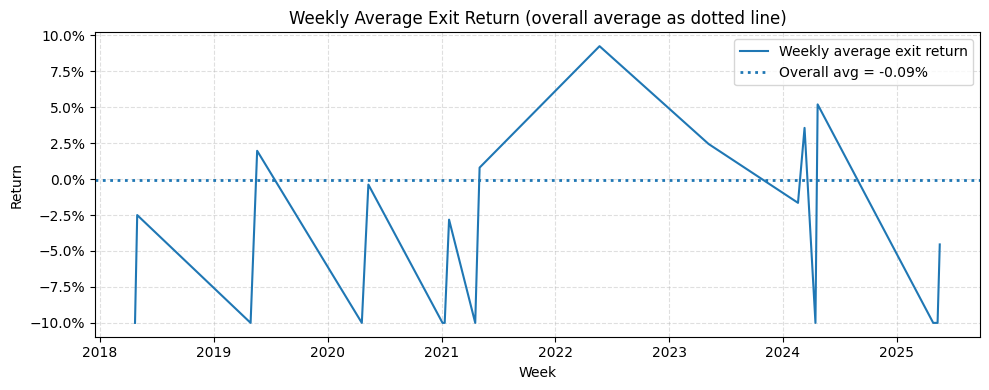

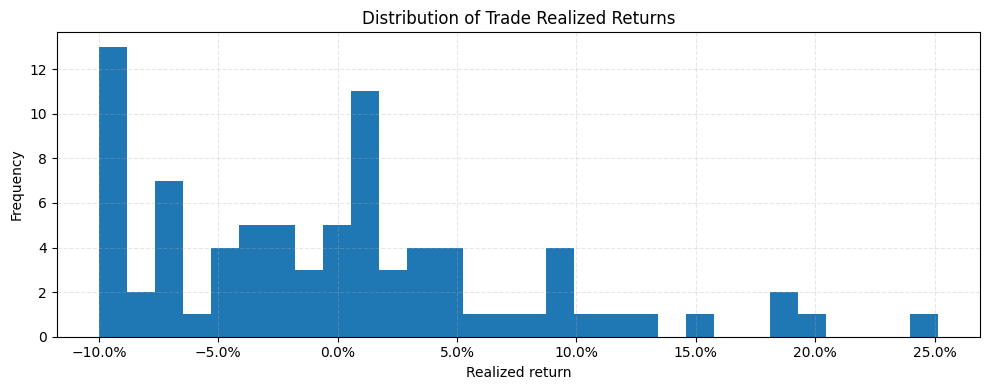

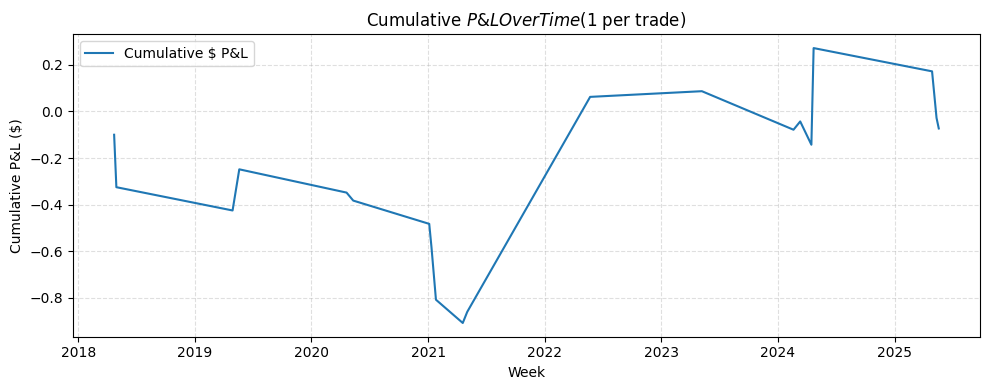

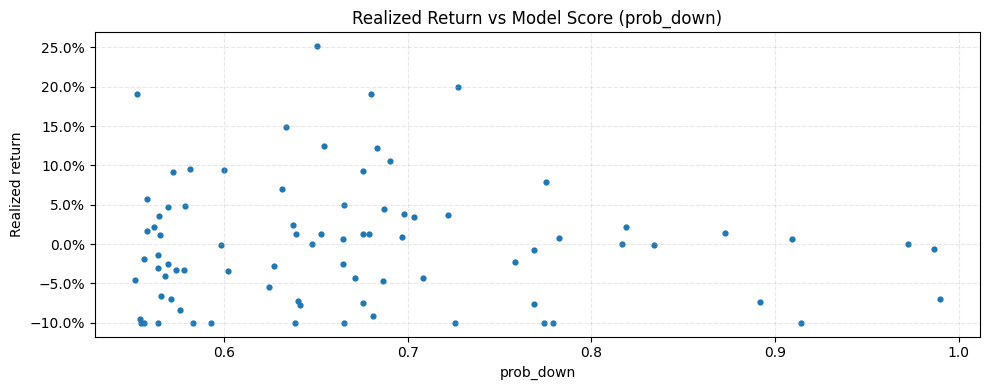

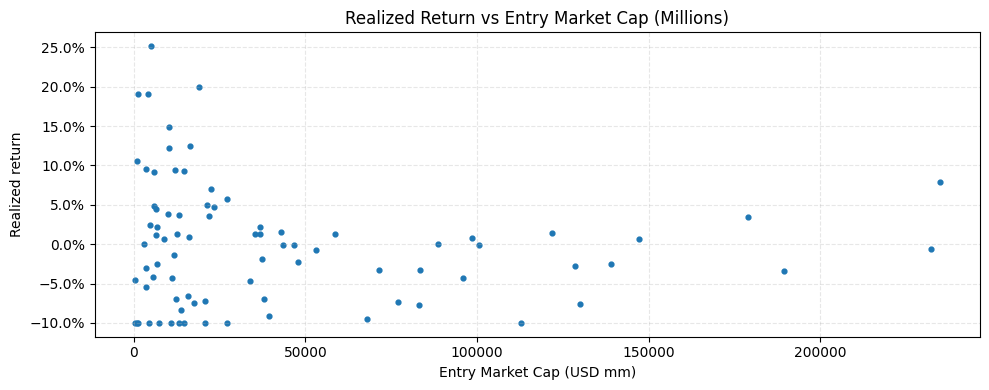

In [161]:
# ==== Trades Report + Return Charts (run after your backtest cell) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# --- Safety checks ---
for _var in ["trades", "df"]:
    if _var not in globals():
        raise NameError(f"Missing '{_var}'. Run your backtest cell first so '{_var}' exists.")

# --- Helper (robust column resolver) ---
def _first_col(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

# --- Prepare copies & normalize dates ---
_tr = trades.copy()
_df = df.copy()
_tr["entry_date"] = pd.to_datetime(_tr["entry_date"]).dt.normalize()
_tr["exit_date"]  = pd.to_datetime(_tr["exit_date"]).dt.normalize()
_df["Date"]       = pd.to_datetime(_df["Date"]).dt.normalize()

# --- Resolve market-cap-at-entry (fall back to sharesOutstanding * price if needed) ---
mc_col = _first_col(_df.columns, ["Market Cap", "Date Market Cap", "Release Date Market Cap"])
if mc_col is None and {"sharesOutstanding", "Date Share Price"}.issubset(_df.columns):
    _df["__mcap__"] = _df["sharesOutstanding"] * _df["Date Share Price"]
    mc_col = "__mcap__"

if mc_col is None:
    # no reliable source; create empty placeholder so the code still runs
    _df["__mcap_placeholder__"] = np.nan
    mc_col = "__mcap_placeholder__"

# Pull entry-time market cap
_entry_mcap = (
    _df[["Ticker", "Date", mc_col]]
      .rename(columns={"Date": "entry_date", mc_col: "entry_mcap"})
)

# --- Build the trades report ---
trades_report = (
    _tr.merge(_entry_mcap, on=["Ticker", "entry_date"], how="left")
       .assign(entry_mcap_millions=lambda x: x["entry_mcap"] / 1e6)
       .loc[:, [
           "Ticker",
           "signal_week",
           "entry_date",
           "exit_date",
           "entry_price",
           "exit_price",
           "realized_ret",
           "prob_down",
           "held_weeks",
           "stopped_out",
           "entry_mcap_millions",
       ]]
       .sort_values(["exit_date", "Ticker"])
       .reset_index(drop=True)
)

# Nice display / optional CSV export
pd.set_option("display.float_format", lambda v: f"{v:,.4f}")
print("\n=== All Trades (incl. market cap in millions) ===")
print(trades_report.to_string(index=False))
# Uncomment to save:
# trades_report.to_csv("trades_report.csv", index=False)

# ======================
# Charts: returns focus
# ======================

# Common helpers
def _ensure_timeline_from_trades(_tr: pd.DataFrame) -> pd.DataFrame:
    if len(_tr) == 0:
        return pd.DataFrame({"date": pd.to_datetime([])})
    tl = pd.DataFrame({"date": pd.to_datetime(sorted(_tr["exit_date"].unique()))})
    tl["date"] = tl["date"].dt.normalize()
    return tl

# 1) Weekly average exit return over time (line) with overall average (dotted)
if len(_tr):
    wk_avg = (_tr.groupby("exit_date", as_index=False)["realized_ret"]
                 .mean()
                 .rename(columns={"exit_date": "date", "realized_ret": "period_ret"}))
    tl = _ensure_timeline_from_trades(_tr)
    wk_avg = tl.merge(wk_avg, on="date", how="left").fillna({"period_ret": 0.0})
    overall_avg = float(_tr["realized_ret"].mean())
else:
    wk_avg = pd.DataFrame({"date": pd.to_datetime([]), "period_ret": pd.Series([], dtype=float)})
    overall_avg = 0.0

plt.figure(figsize=(10, 4))
if len(wk_avg):
    plt.plot(wk_avg["date"], wk_avg["period_ret"], label="Weekly average exit return")
plt.axhline(overall_avg, linestyle=":", linewidth=2, label=f"Overall avg = {overall_avg:.2%}")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.title("Weekly Average Exit Return (overall average as dotted line)")
plt.xlabel("Week")
plt.ylabel("Return")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Histogram of trade realized returns
plt.figure(figsize=(10, 4))
if len(_tr):
    plt.hist(_tr["realized_ret"].astype(float), bins=30)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
plt.title("Distribution of Trade Realized Returns")
plt.xlabel("Realized return")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Cumulative $ P&L over time (using $1 per trade)
if len(_tr):
    weekly_pnl = (_tr.groupby("exit_date", as_index=False)["realized_ret"]
                    .sum()
                    .rename(columns={"exit_date": "date", "realized_ret": "weekly_pnl_$"}))
    weekly_pnl["date"] = pd.to_datetime(weekly_pnl["date"]).dt.normalize()
    weekly_pnl = weekly_pnl.sort_values("date")
    weekly_pnl["cum_pnl_$"] = weekly_pnl["weekly_pnl_$"].cumsum()
else:
    weekly_pnl = pd.DataFrame({"date": pd.to_datetime([]), "weekly_pnl_$": pd.Series([], dtype=float), "cum_pnl_$": pd.Series([], dtype=float)})

plt.figure(figsize=(10, 4))
if len(weekly_pnl):
    plt.plot(weekly_pnl["date"], weekly_pnl["cum_pnl_$"], label="Cumulative $ P&L")
plt.title("Cumulative $ P&L Over Time ($1 per trade)")
plt.xlabel("Week")
plt.ylabel("Cumulative P&L ($)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 4) Scatter: model score vs realized return
plt.figure(figsize=(10, 4))
if len(_tr):
    plt.scatter(_tr["prob_down"].astype(float), _tr["realized_ret"].astype(float), s=12)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.title("Realized Return vs Model Score (prob_down)")
plt.xlabel("prob_down")
plt.ylabel("Realized return")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# 5) Scatter: entry market cap (millions) vs realized return
plt.figure(figsize=(10, 4))
if len(trades_report):
    plt.scatter(trades_report["entry_mcap_millions"].astype(float), _tr["realized_ret"].astype(float), s=12)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.title("Realized Return vs Entry Market Cap (Millions)")
plt.xlabel("Entry Market Cap (USD mm)")
plt.ylabel("Realized return")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [158]:
# parameters you can tweak
PICKS_MIN      = 1
PICKS_MAX      = 10
MIN_PROB_FLOOR = 0.60
MIN_MCAP       = 300_000_000   # entry-time market cap filter
EXCLUDE_OPEN   = True          # exclude names already open as of AS_OF if 'trades' exists

def _first_col(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

# normalize copies
dfc = df.copy()
dfc["Date"] = pd.to_datetime(dfc["Date"]).dt.normalize()

REL_COL = _first_col(dfc.columns, ["ReleaseDate","Release Date","Release_Date","ReleaseDate_norm"])
if REL_COL is None:
    raise KeyError("Need a release-date column in df.")
dfc[REL_COL] = pd.to_datetime(dfc[REL_COL]).dt.normalize()

# pick AS_OF = today (fallback to latest date in data)
AS_OF = pd.Timestamp.today().normalize()
if AS_OF not in set(dfc["Date"].unique()):
    AS_OF = dfc["Date"].max()

# today's feature snapshot
today = dfc[dfc["Date"] == AS_OF].copy()
mask = np.isfinite(today[ZCOLS]).all(axis=1)
today = today.loc[mask].copy()

# optionally exclude names already open as of AS_OF
if EXCLUDE_OPEN and "trades" in globals() and isinstance(trades, pd.DataFrame) and len(trades):
    tt = trades.copy()
    tt["entry_date"] = pd.to_datetime(tt["entry_date"]).dt.normalize()
    tt["exit_date"]  = pd.to_datetime(tt["exit_date"]).dt.normalize()
    open_names = set(tt.loc[(tt["entry_date"] <= AS_OF) & (tt["exit_date"] > AS_OF), "Ticker"])
    if open_names:
        today = today[~today["Ticker"].isin(open_names)].copy()

# score with your classifier
today["prob_down"] = clf.predict_proba(today[ZCOLS].values)[:, 1]

# only consider entries whose release date is not before AS_OF
today = today[today[REL_COL] >= AS_OF].copy()

# entry-time market cap (use column if present, else sharesOutstanding * entry price)
mc_col = _first_col(dfc.columns, ["Market Cap","Date Market Cap","Release Date Market Cap"])
px_col = _first_col(dfc.columns, ["Date Share Price","Close","Adj Close","Price"])

entry_cols = ["Ticker","Date"]
if px_col: entry_cols.append(px_col)
if mc_col: entry_cols.append(mc_col)
if "sharesOutstanding" in dfc.columns: entry_cols.append("sharesOutstanding")

entry_snap = dfc[entry_cols].rename(columns={"Date":"entry_date"})
if px_col: entry_snap = entry_snap.rename(columns={px_col:"entry_price"})
candidates = today.merge(entry_snap, left_on=["Ticker", REL_COL], right_on=["Ticker","entry_date"], how="left")

if mc_col and mc_col in candidates.columns:
    candidates["entry_mcap"] = candidates[mc_col]
else:
    if {"sharesOutstanding","entry_price"}.issubset(candidates.columns):
        candidates["entry_mcap"] = candidates["sharesOutstanding"] * candidates["entry_price"]
    else:
        candidates["entry_mcap"] = np.nan

# apply mcap and top-K selection
candidates = candidates[np.isfinite(candidates["entry_mcap"])]
candidates = candidates[candidates["entry_mcap"] >= MIN_MCAP].copy()

cand_sorted = candidates.sort_values("prob_down", ascending=False).reset_index(drop=True)
picks = cand_sorted[cand_sorted["prob_down"] >= MIN_PROB_FLOOR].head(PICKS_MAX)
if len(picks) < PICKS_MIN:
    picks = cand_sorted.head(min(PICKS_MIN, len(cand_sorted)))
picks = picks.head(PICKS_MAX)

# output just the tickers as a table
tickers_df = picks[["Ticker"]].drop_duplicates().reset_index(drop=True)
pd.set_option("display.float_format", lambda v: f"{v:,.4f}")
print(f"AS_OF week: {AS_OF.date()}  |  Tickers: {len(tickers_df)}")
print(tickers_df.to_string(index=False))


AS_OF week: 2025-08-25  |  Tickers: 0
Empty DataFrame
Columns: [Ticker]
Index: []
